In [1]:
%load_ext autoreload
%autoreload 2

In [49]:
import jax
rkey = jax.random.PRNGKey(1)
from numpyro.infer import NUTS,MCMC
import arviz as az # need v>=0.14
import numpy as np
import jax.numpy as jnp
import matplotlib.pyplot as plt
from astropy.modeling.functional_models import Sersic2D
from astropy.convolution import convolve,Gaussian2DKernel
import numpyro
import numpyro.distributions as dist

grid = np.arange(0,250)
X,Y = np.meshgrid(grid,grid)
s2d = Sersic2D(r_eff = 6.5,n = 2, x_0 = 125.5, y_0 = 125.5, ellip = 0.2, theta = 0.7)
im = s2d(X,Y)
im = im*250./np.sum(im)

grid2 = np.arange(0,31)
X,Y = np.meshgrid(grid2,grid2)
psf = Gaussian2DKernel(1)*0.7 + 0.3*Gaussian2DKernel(2.5)

psf_sig = np.array([1,2.5])
psf_a = np.array([0.7,0.3])

noise = 1e-4

sci = convolve(im,psf) + np.random.normal(loc = 0, scale = noise, size = im.shape)+5e-3
w_im = np.ones_like(sci)/ noise**2
mask = np.zeros_like(sci)
sig = np.logspace(np.log10(0.5), np.log10(50), num =11)

/tmp/ipykernel_279/4021863576.py:1: RuntimeWarning: invalid value encountered in log10
  plt.imshow(np.log10(sci-5e-3))


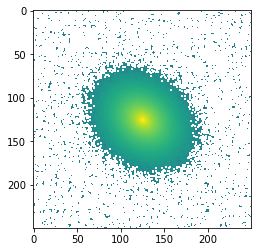

In [50]:
plt.imshow(np.log10(sci-5e-3))

In [51]:
from imcascade.fitter import Fitter,numpyro_model, get_priors_results
from imcascade import ImcascadeResults
from imcascade.utils import sersic, asinh_scale,log_scale
sig = log_scale(0.75, 60, 9)
print (sig)

[ 0.75        1.29702251  2.24302317  3.87900204  6.70820393 11.60092196
 20.06220915 34.69484903 60.        ]


In [52]:
class Fitter_NP(Fitter):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        inds = np.arange(self.N_gauss)
        log_sig_re = np.log10(self.sig/self.init_dict['re'])
        self.med_prior_frac = self.init_dict['flux']*0.3*np.exp(-(log_sig_re+0.1)**2/ (2*0.4**2))
        self.sig_prior_frac = 0.15*self.init_dict['flux']
        
    def generate_comp_fluxes(self):
        comp_weights_raw = numpyro.sample('comp_weights_raw', dist.Normal(), sample_shape =(self.N_gauss,))
        comp_fluxes = numpyro.deterministic('comp_fluxes', self.sig_prior_frac*comp_weights_raw + self.med_prior_frac)
        return comp_fluxes

fdp = Fitter_NP(sci,sig, psf_sig,psf_a, weight = w_im, sky_model = True, init_dict=dict(re = 4))
fdp.validate_generators()

True

In [53]:
from jax.example_libraries.optimizers import exponential_decay

In [56]:
N = 3000
#exponential_decay(0.01, N/10, 0.99)
res_dict = fdp.fit(guide_model = numpyro.infer.autoguide.AutoBNAFNormal,use_posterior = True,run_kwargs = {'num_steps': N,}, optimizer_kwargs={'step_size': 5e-2})

rdp_samp = ImcascadeResults(fdp)
rdp_samp.run_basic_analysis()

100%|██████████| 3000/3000 [00:29<00:00, 102.87it/s, init loss: 577843.0625, avg. loss [2851-3000]: 65.4358]


{'flux': array([251.03619385,   9.46004028,   8.59828613]),
 'r20': array([2.55116038, 0.08583486, 0.07934978]),
 'r50': array([6.56249784, 0.31293434, 0.30571699]),
 'r80': array([14.80009912,  1.27451742,  1.42106631]),
 'r90': array([21.81248304,  2.91146172,  3.92849478]),
 'C80_20': array([5.80474819, 0.32476964, 0.37205122]),
 'C90_50': array([3.32499219, 0.29674812, 0.43857725])}

array([[<AxesSubplot:title={'center':'comp_fluxes\n0'}>,
        <AxesSubplot:title={'center':'comp_fluxes\n1'}>,
        <AxesSubplot:title={'center':'comp_fluxes\n2'}>],
       [<AxesSubplot:title={'center':'comp_fluxes\n3'}>,
        <AxesSubplot:title={'center':'comp_fluxes\n4'}>,
        <AxesSubplot:title={'center':'comp_fluxes\n5'}>],
       [<AxesSubplot:title={'center':'comp_fluxes\n6'}>,
        <AxesSubplot:title={'center':'comp_fluxes\n7'}>,
        <AxesSubplot:title={'center':'comp_fluxes\n8'}>]], dtype=object)

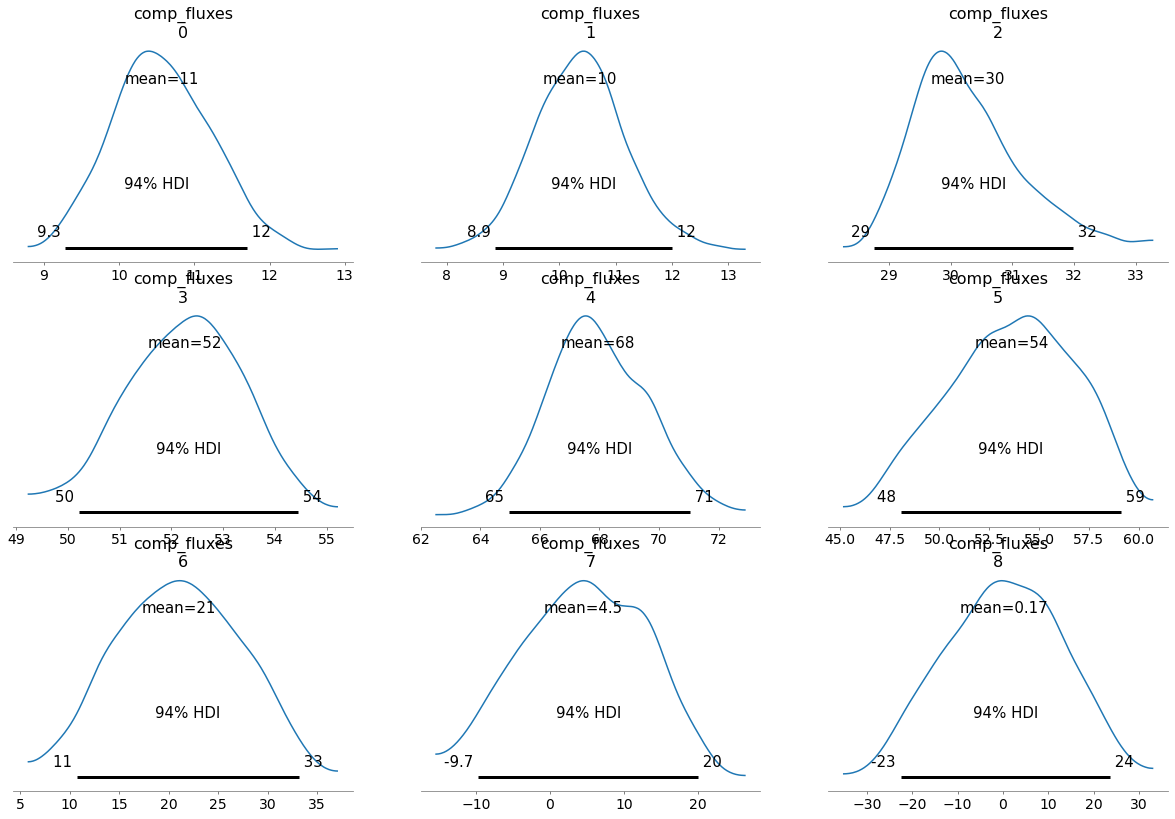

In [57]:
az.plot_posterior(fdp.arvizID, var_names = ['comp_fluxes'])

In [58]:
dp_samp = fdp.sample(
    mcmc_kwargs={'num_warmup':500, 'num_samples':500, 'num_chains':2},
    sampler_kwargs = {},
    neutra_reparam = False)
rdp_samp = ImcascadeResults(fdp)
rdp_samp.run_basic_analysis()

/mnt/c/Users/timbl/Documents/files/research/packages/imcascade/imcascade/fitter.py:370: UserWarning: There are not enough devices to run parallel chains: expected 2 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(2)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc_kernel = infer.MCMC(mcmc_sampler,**mcmc_kwargs)
warmup:   6%|▋         | 64/1000 [00:54<18:30,  1.19s/it, 127 steps of size 3.86e-03. acc. prob=0.74] 

In [24]:
az.summary(fdp.arvizID)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
comp_fluxes[0],40.523,8.752,23.851,56.262,0.386,0.277,517.0,626.0,1.01
comp_fluxes[1],28.081,18.370,-1.708,66.030,0.858,0.607,460.0,557.0,1.01
comp_fluxes[2],59.970,18.023,26.517,91.612,0.851,0.619,452.0,659.0,1.01
comp_fluxes[3],66.634,15.972,38.244,98.254,0.675,0.477,557.0,680.0,1.00
comp_fluxes[4],41.196,16.794,6.886,70.775,0.663,0.483,633.0,616.0,1.00
comp_fluxes[5],12.026,20.096,-24.640,53.027,0.785,0.592,658.0,679.0,1.00
comp_fluxes[6],2.883,23.338,-42.528,44.802,0.862,0.739,746.0,683.0,1.01
comp_fluxes[7],-1.303,27.502,-50.552,52.402,0.918,0.853,894.0,703.0,1.00
comp_fluxes[8],-2.024,31.955,-57.596,60.355,1.055,1.003,914.0,748.0,1.00
comp_weights_raw[0],0.506,0.236,0.057,0.930,0.010,0.008,517.0,626.0,1.01


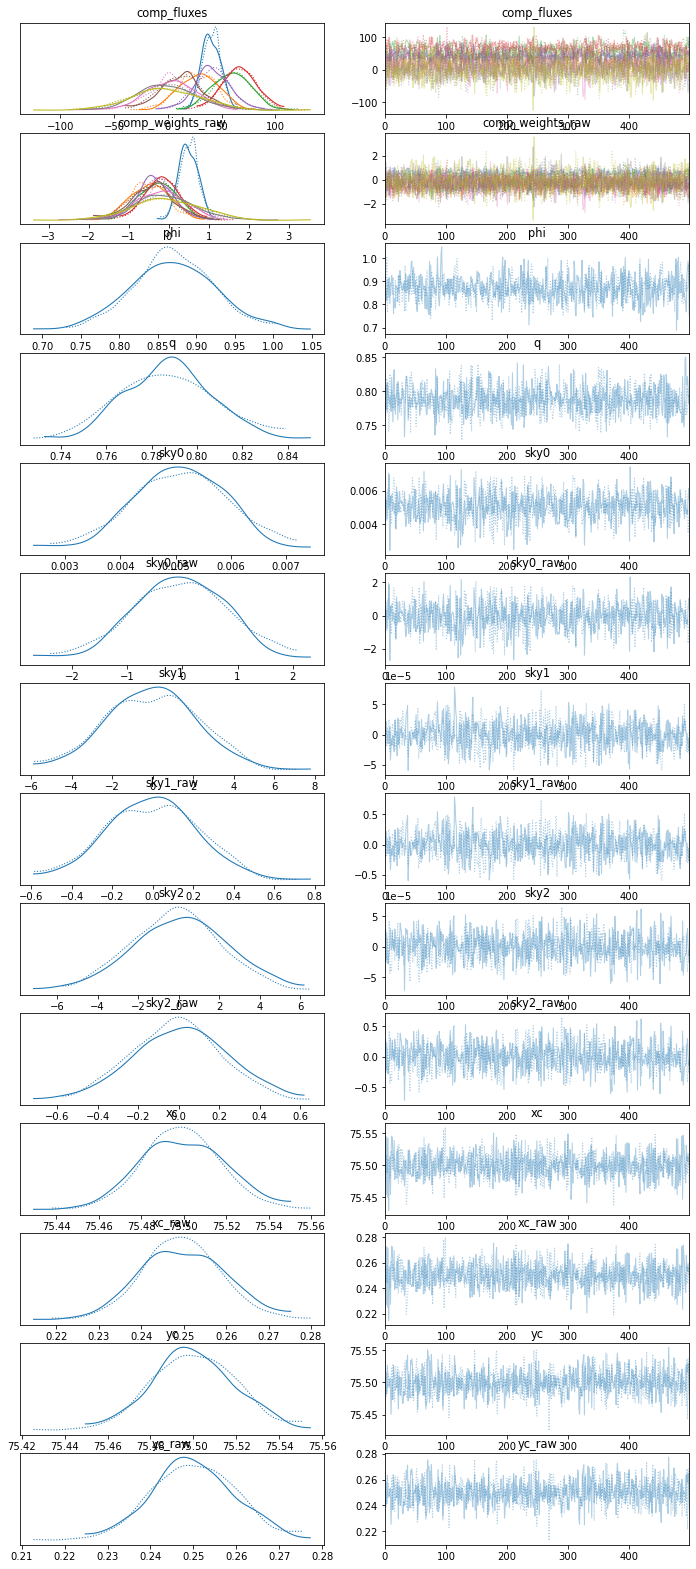

In [25]:
az.plot_trace(fdp.arvizID);

In [17]:
dp_res = get_priors_results(fdp)
dp_res.posterior['comp_weights'].median(axis = 1).data

array([0.00663539, 0.03171775, 0.07741117, 0.14579254, 0.19487998,
       0.18334088, 0.12160325, 0.05461669, 0.01666577], dtype=float32)

In [18]:
dpres = fdp.fit(use_posterior=True, guide_model = numpyro.infer.autoguide.AutoBNAFNormal)
rdp = ImcascadeResults(fdp)
rdp.run_basic_analysis()

100%|██████████| 2500/2500 [00:14<00:00, 169.92it/s, init loss: 78273.1562, avg. loss [2376-2500]: -71515.5469]


{'flux': array([249.48464966,   3.59846558,   3.81667664]),
 'r20': array([3.42967215, 0.03355287, 0.03415639]),
 'r50': array([6.98191064, 0.09121859, 0.09945416]),
 'r80': array([12.45553969,  0.29838262,  0.33699938]),
 'r90': array([16.13216597,  0.59326144,  0.73566622]),
 'C80_20': array([3.63192344, 0.05136548, 0.06295795]),
 'C90_50': array([2.31042415, 0.0561392 , 0.07220606])}

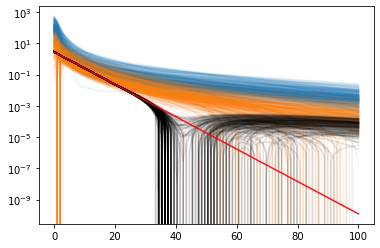

In [26]:
r_plot = np.linspace(0, 100, num = 100)
r_ser = sersic(r_plot, 1, 7, 250)/0.8

prior_sbp = prior_res.calc_sbp(r_plot)
rdp_sbp = rdp.calc_sbp(r_plot)
runi_sbp = rtest.calc_sbp(r_plot)
dp_sbp = dp_res.calc_sbp(r_plot)

plt.plot(r_plot, prior_sbp[:,:250], 'C0-', alpha = 0.1)
plt.plot(r_plot, dp_sbp[:,:250], 'C1-', alpha = 0.1)
plt.plot(r_plot, rdp_sbp[:,:250], 'k-', alpha = 0.1)
plt.plot(r_plot, r_ser, 'r-', alpha = 0.9)
plt.yscale('log')
#plt.ylim([-1e-2,1e-2])

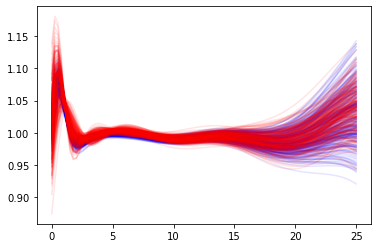

In [22]:
r_plot = np.linspace(0., 25, num = 100)
rdp_sbp = rdp.calc_sbp(r_plot)
rdp_samp_sbp = rdp_samp.calc_sbp(r_plot)

runi_sbp = rtest.calc_sbp(r_plot)
r_ser = sersic(r_plot, 1., 7, 250)/0.8
plt.plot(r_plot, rdp_sbp[:,:250]/r_ser[:,None], 'b-', alpha = 0.1)
plt.plot(r_plot, rdp_samp_sbp[:,:250]/r_ser[:,None], 'r-', alpha = 0.1)

#plt.yscale('log')
plt.show()

In [268]:
ftest = Fitter(sci,sig, psf_sig,psf_a, weight = w_im, sky_model = True, init_dict=dict(re = 10))
dres = ftest.fit(use_posterior=True)
az.summary(ftest.arvizID)

100%|██████████| 2500/2500 [00:11<00:00, 212.62it/s, init loss: 6693507.0000, avg. loss [2376-2500]: -71636.6172]
/mnt/c/Users/timbl/Documents/files/research/packages/imcascade/imcascade/fitter.py:388: UserWarning: Hessian of log posterior at the MAP point is singular. Posterior samples from AutoLaplaceApproxmiation will be constant (equal to the MAP point). Please consider using an AutoNormal guide.
  post_raw = guide.sample_posterior(self.rkey, svi_result.params, sample_shape = ((1000,)))
Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
comp_fluxes[0],-0.641,0.000,-0.641,-0.641,0.0,0.0,1000.0,1000.0,NaN
comp_fluxes[1],9.520,0.000,9.520,9.520,0.0,0.0,1000.0,1000.0,NaN
comp_fluxes[2],4.250,0.000,4.250,4.250,0.0,0.0,1000.0,1000.0,NaN
comp_fluxes[3],68.597,0.001,68.596,68.596,0.0,0.0,1000.0,1000.0,NaN
comp_fluxes[4],112.358,0.001,112.357,112.357,0.0,0.0,1000.0,1000.0,NaN
comp_fluxes[5],60.780,0.001,60.780,60.780,0.0,0.0,1000.0,1000.0,NaN
comp_fluxes[6],-2.409,0.000,-2.409,-2.409,0.0,0.0,1000.0,1000.0,NaN
comp_fluxes[7],-6.310,0.000,-6.310,-6.310,0.0,0.0,1000.0,1000.0,NaN
comp_fluxes[8],-4.241,0.000,-4.241,-4.241,0.0,0.0,1000.0,1000.0,NaN
comp_fluxes_raw[0],-0.003,0.000,-0.003,-0.003,0.0,0.0,1000.0,1000.0,NaN


In [270]:
from imcascade import ImcascadeResults
rtest = ImcascadeResults(ftest)
rtest.run_basic_analysis(zpt = 27)

{'flux': array([241.90054321,   0.        ,   0.        ]),
 'mag': array([21.04090881,  0.        ,  0.        ]),
 'r20': array([3.35154988, 0.        , 0.        ]),
 'r50': array([6.77830228, 0.        , 0.        ]),
 'r80': array([11.82966161,  0.        ,  0.        ]),
 'r90': array([14.95526701,  0.        ,  0.        ]),
 'C80_20': array([3.52960929, 0.        , 0.        ]),
 'C90_50': array([2.20634406, 0.        , 0.        ])}

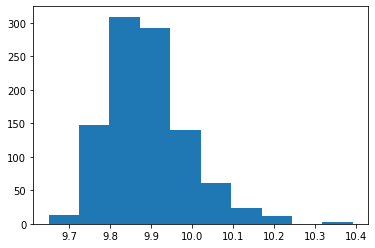

In [54]:
plt.hist( rtest.calc_r50());